##### Good resource: https://www.kaggle.com/code/iamleonie/intro-to-time-series-forecasting

In [159]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Read in the data
df=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/rotten-tomatoes-analysis/main/data/rotten_tomatoes_movies.csv")
print(df.shape)

(17712, 22)


In [160]:
del df['rotten_tomatoes_link'], df['tomatometer_top_critics_count'], df['tomatometer_fresh_critics_count'], df['tomatometer_rotten_critics_count']

In [161]:
#Create new features
df[['og_year','og_month','og_day']] = df['original_release_date'].str.split('-',expand=True)
df[['str_year','str_month','str_day']] = df['streaming_release_date'].str.split('-',expand=True)
df['num_actors'] = df['actors'].str.count(',')+1
df['num_actors_group'] = pd.cut(df['num_actors'],
                      bins=[0, 5, 10, 25, 100, float('Inf')],
                      labels=['0-10', '10-25', '25-50','50-100','100+'])

In [162]:
df = df[(df['og_year'].notna()) & (df['str_year'].notna())]
df.shape

(16305, 26)

In [163]:
#Convert time features to integers
df['og_year'] = df['og_year'].astype(int)
df['str_year'] = df['str_year'].astype(int)

df['og_month'] = df['og_month'].astype(int)
df['str_month'] = df['str_month'].astype(int)

df['og_day'] = df['og_day'].astype(int)
df['str_day'] = df['str_day'].astype(int)

In [164]:
from nltk.tokenize import RegexpTokenizer
#!pip install contractions
import contractions
import re

def punct(text):
    token=RegexpTokenizer(r'\w+')#regex
    text = token.tokenize(text)
    text= " ".join(text)
    return text 

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def lemmatize(text):
    lemmed = contractions.fix(str(text))
    return lemmed


In [165]:
#Apply standardizing functions to synopsis and critic text
from nltk.corpus import stopwords

stop = stopwords.words('english')

#0.) Convert everything to string
df['cleaned_movie_info'] = df['movie_info'].astype(str)
df['cleaned_critics_consensus'] = df['critics_consensus'].astype(str)

#1.) Lowercase
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].str.lower()
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].str.lower()

#2.) Remove punctuation
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = punct)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = punct)

#3.) Remove non alpha-numeric characters
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = remove_special_characters)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = remove_special_characters)

#4.) Remove digits
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = remove_digits)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = remove_digits)

#5.) Lemmatize words
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = lemmatize)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = lemmatize)

#6. Remove stop words
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [166]:
#Set up VADER score to get labels for doing classification later
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
df['synposis_scores_unpack'] = df['cleaned_movie_info'].map(lambda x: sia.polarity_scores(x))
df['critic_scores_unpack'] = df['cleaned_critics_consensus'].map(lambda x: sia.polarity_scores(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jonzimmerman/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [167]:
df['synopsis_sentiment_score']  = df['synposis_scores_unpack'].apply(lambda score_dict: score_dict['compound'])
df['synopsis_sentiment_class'] = df['synopsis_sentiment_score'].apply(lambda x: 1 if x >=0 else 0)
df['critic_sentiment_score']  = df['critic_scores_unpack'].apply(lambda score_dict: score_dict['compound'])
df['critic_sentiment_class'] = df['critic_sentiment_score'].apply(lambda x: 1 if x >=0 else 0)
df.head(2)

,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,...,num_actors,num_actors_group,cleaned_movie_info,cleaned_critics_consensus,synposis_scores_unpack,critic_scores_unpack,synopsis_sentiment_score,synopsis_sentiment_class,critic_sentiment_score,critic_sentiment_class
0,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2015-11-25,...,87.0,50-100,always trouble prone life teenager percy jacks...,though may seem like another harry potter knoc...,"{'neg': 0.215, 'neu': 0.55, 'pos': 0.235, 'com...","{'neg': 0.0, 'neu': 0.507, 'pos': 0.493, 'comp...",-0.2023,0,0.9274,1
1,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2012-09-04,...,8.0,10-25,kate catherine keener husband alex oliver plat...,nicole holofcener newest might seem slight pla...,"{'neg': 0.089, 'neu': 0.789, 'pos': 0.121, 'co...","{'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'comp...",0.2023,1,0.3612,1


### Time Series Forecasting

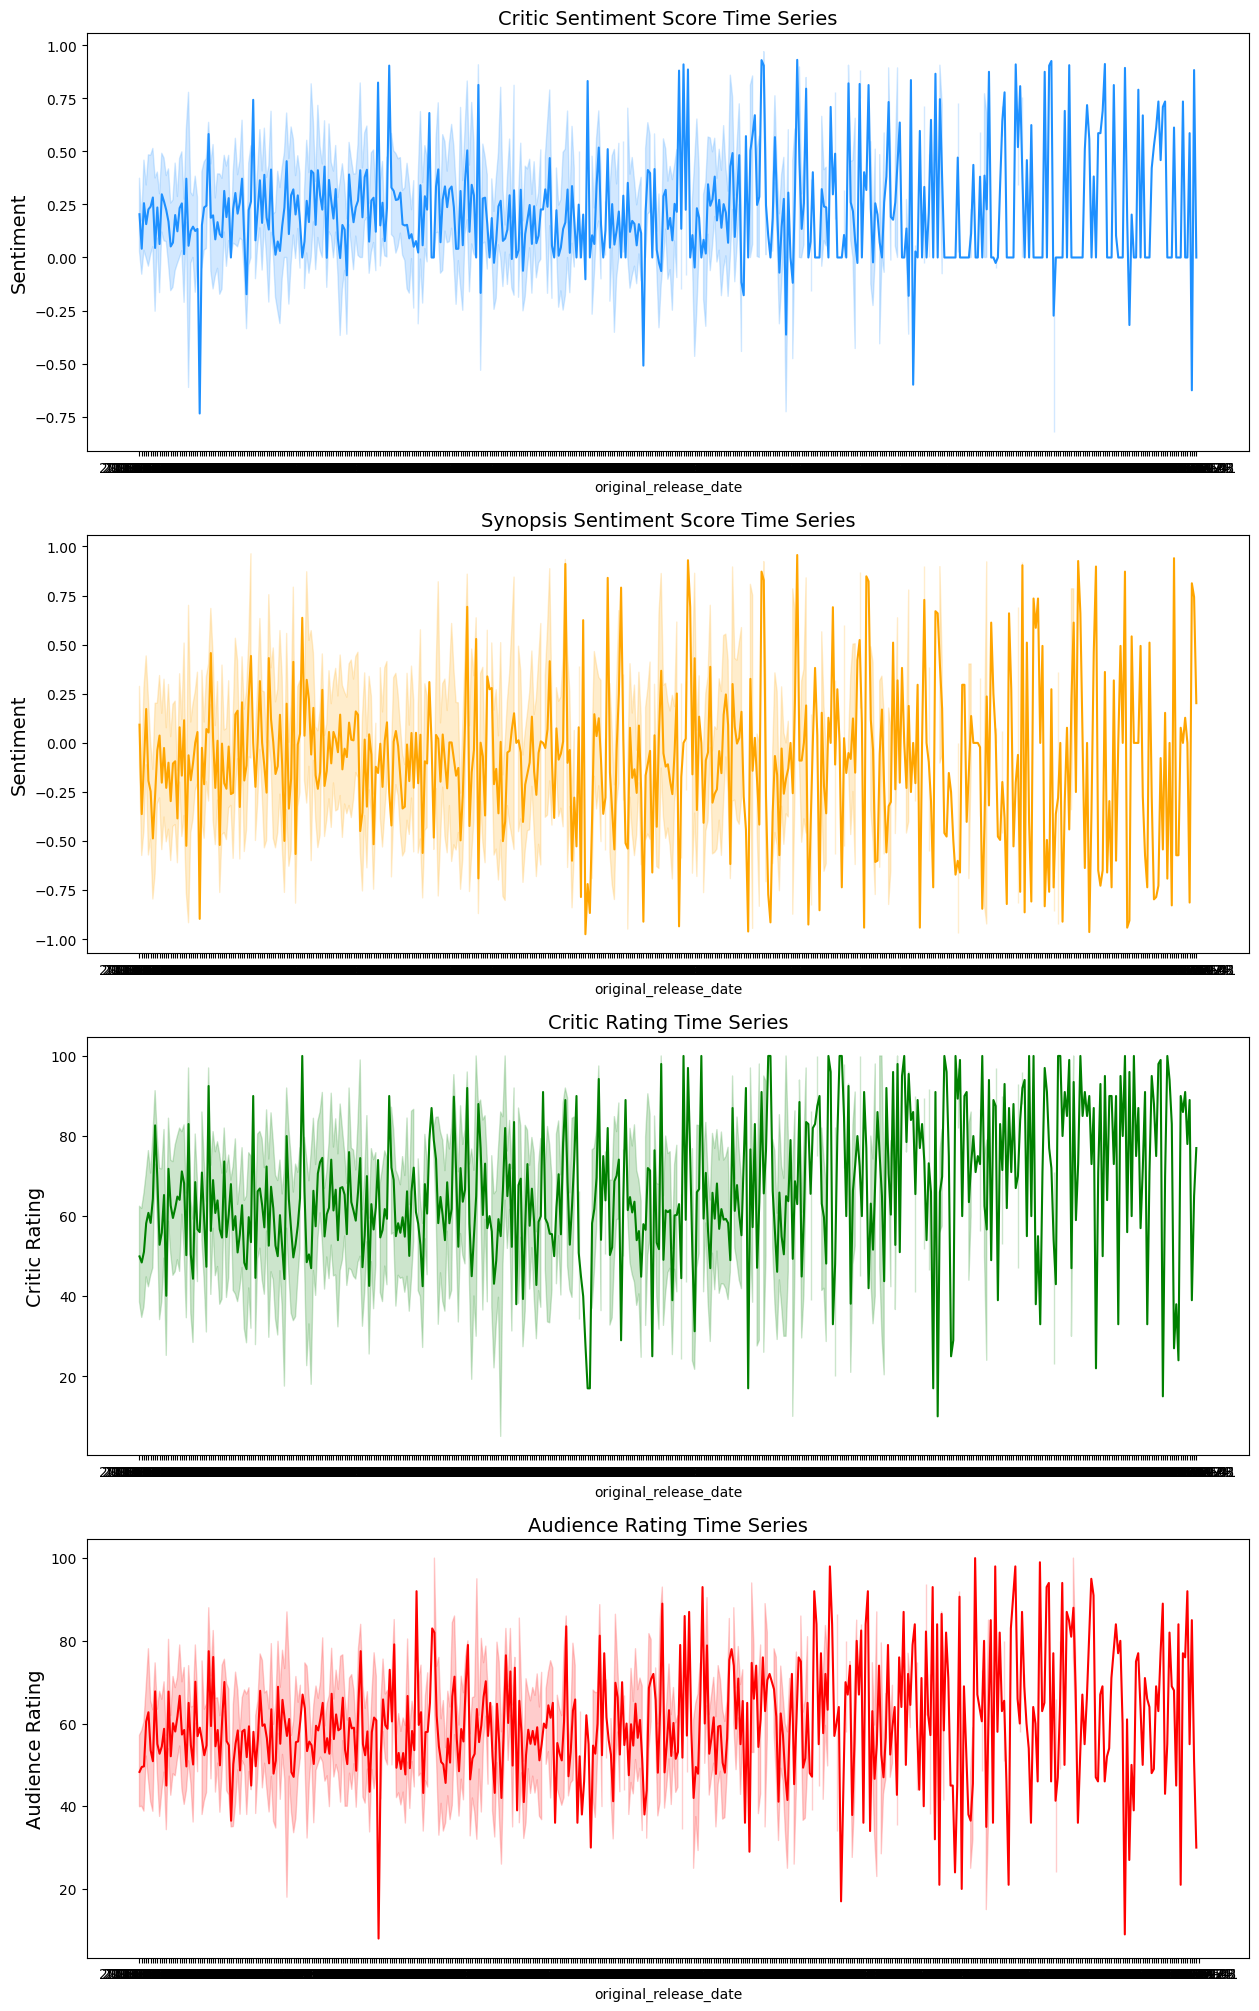

In [168]:
import seaborn as sns

plot_df = df[(df['original_release_date']>='2015-01-01') & ((df['original_release_date']<='2020-01-01'))]

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))

sns.lineplot(x=plot_df['original_release_date'], y=plot_df['critic_sentiment_score'], ax=ax[0], color='dodgerblue')
ax[0].set_title('Critic Sentiment Score Time Series', fontsize=14)
ax[0].set_ylabel(ylabel='Sentiment', fontsize=14)


sns.lineplot(x=plot_df['original_release_date'], y=plot_df['synopsis_sentiment_score'], ax=ax[1], color='orange')
ax[1].set_title('Synopsis Sentiment Score Time Series', fontsize=14)
ax[1].set_ylabel(ylabel='Sentiment', fontsize=14)


sns.lineplot(x=plot_df['original_release_date'], y=plot_df['tomatometer_rating'], ax=ax[2], color='green')
ax[2].set_title('Critic Rating Time Series', fontsize=14)
ax[2].set_ylabel(ylabel='Critic Rating', fontsize=14)

sns.lineplot(x=plot_df['original_release_date'], y=plot_df['audience_rating'], ax=ax[3], color='red')
ax[3].set_title('Audience Rating Time Series', fontsize=14)
ax[3].set_ylabel(ylabel='Audience Rating', fontsize=14)

plt.show()

## Data Preprocessing

#### The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data (see Resampling).

In [208]:
#Filter data where intervals are all in one month range
time_df = df[df['original_release_date']>='1971-01-01']
time_df = time_df.sort_values(by='original_release_date')

#Create the year-month variable
time_df['original_release_ym'] =  pd.to_datetime(time_df['original_release_date'])
time_df['original_release_ym'] = time_df['original_release_ym'].dt.strftime('%Y-%m')
time_df['original_release_ym'] =  pd.to_datetime(time_df['original_release_ym'])

#Create new dataframe 
ym_df = time_df.groupby('original_release_ym').agg({
    'critic_sentiment_score': 'mean',
    'synopsis_sentiment_score':'mean',
    'tomatometer_rating':'mean',
    'audience_rating':'mean'
}).reset_index()

ym_df.head()

,original_release_ym,critic_sentiment_score,synopsis_sentiment_score,tomatometer_rating,audience_rating
0,1971-01-01,0.019210,-0.306400,80.100000,71.300000
1,1971-02-01,0.153100,-0.543250,61.750000,60.000000
2,1971-03-01,0.161767,0.286833,82.166667,69.166667
3,1971-04-01,0.000000,0.152340,50.600000,49.800000
4,1971-05-01,0.111480,0.483580,54.600000,52.200000


In [209]:
ym_df.dtypes

original_release_ym         datetime64[ns]
critic_sentiment_score             float64
synopsis_sentiment_score           float64
tomatometer_rating                 float64
audience_rating                    float64
dtype: object

In [210]:
# Check time intervals
ym_df['time_interval'] = ym_df['original_release_ym'] - ym_df['original_release_ym'].shift(1)
ym_df['time_interval'].value_counts()

31 days    348
30 days    198
28 days     37
29 days     13
Name: time_interval, dtype: int64

In [211]:
ym_df.isnull().sum()

original_release_ym         0
critic_sentiment_score      0
synopsis_sentiment_score    0
tomatometer_rating          0
audience_rating             0
time_interval               1
dtype: int64

In [212]:
del ym_df['time_interval']

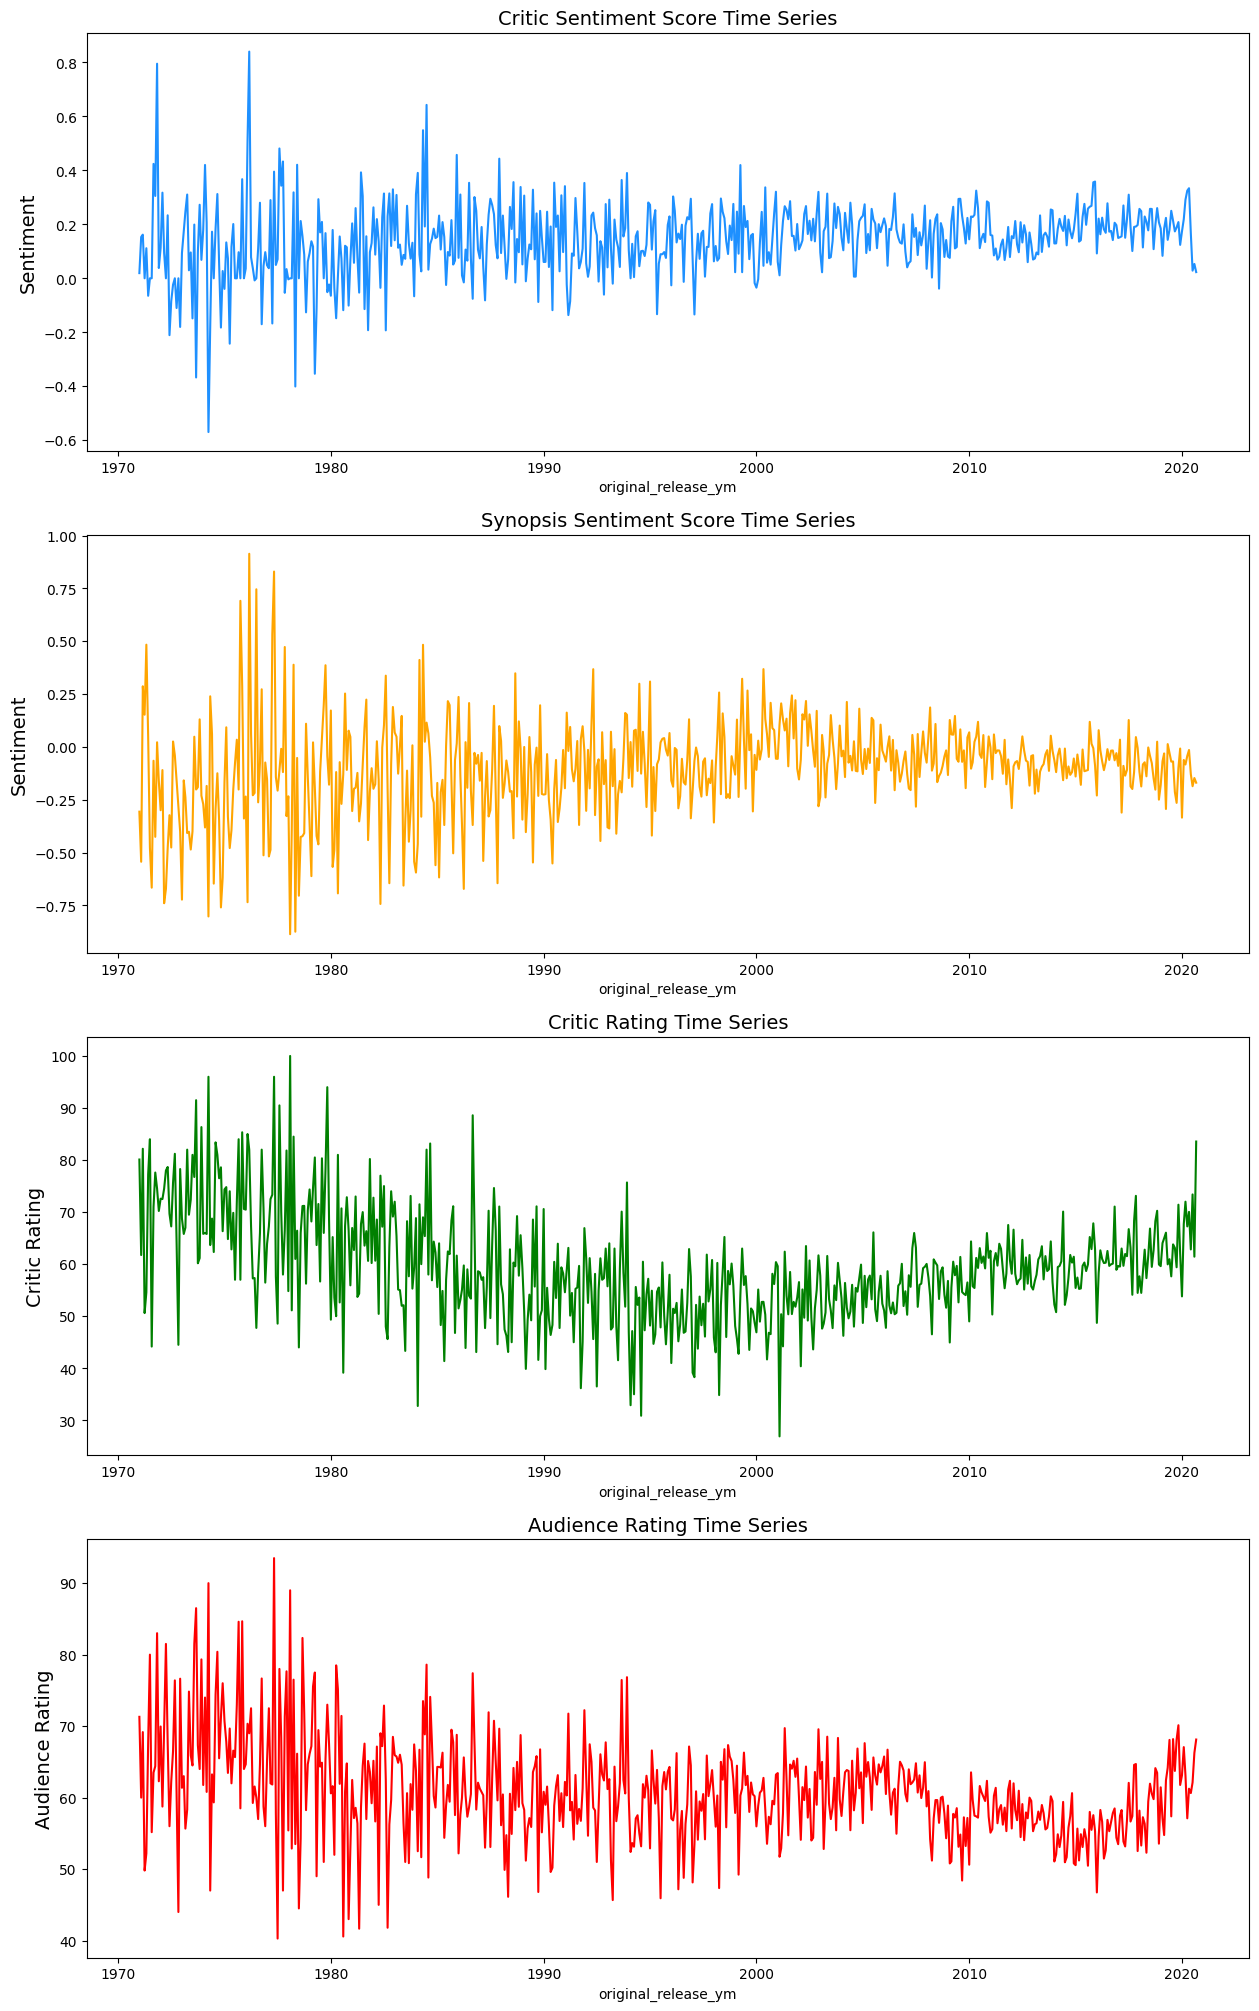

In [213]:
import seaborn as sns

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))

sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['critic_sentiment_score'], ax=ax[0], color='dodgerblue')
ax[0].set_title('Critic Sentiment Score Time Series', fontsize=14)
ax[0].set_ylabel(ylabel='Sentiment', fontsize=14)


sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['synopsis_sentiment_score'], ax=ax[1], color='orange')
ax[1].set_title('Synopsis Sentiment Score Time Series', fontsize=14)
ax[1].set_ylabel(ylabel='Sentiment', fontsize=14)


sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['tomatometer_rating'], ax=ax[2], color='green')
ax[2].set_title('Critic Rating Time Series', fontsize=14)
ax[2].set_ylabel(ylabel='Critic Rating', fontsize=14)

sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['audience_rating'], ax=ax[3], color='red')
ax[3].set_title('Audience Rating Time Series', fontsize=14)
ax[3].set_ylabel(ylabel='Audience Rating', fontsize=14)

plt.show()

### Stationarity


#### Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

##### a.) constant mean and mean is not time-dependent
##### b.) constant variance and variance is not time-dependent
##### c.) constant covariance and covariance is not time-dependent

#### If a time series has a specific (stationary) behavior over a given time interval, then it can be assumed that the time series will behave the same at a later time.

#### Time series with trend and/or seasonality are not stationary. Trend indicates that the mean is not constant over time and seasonality indicates that the variance is not constant over time.

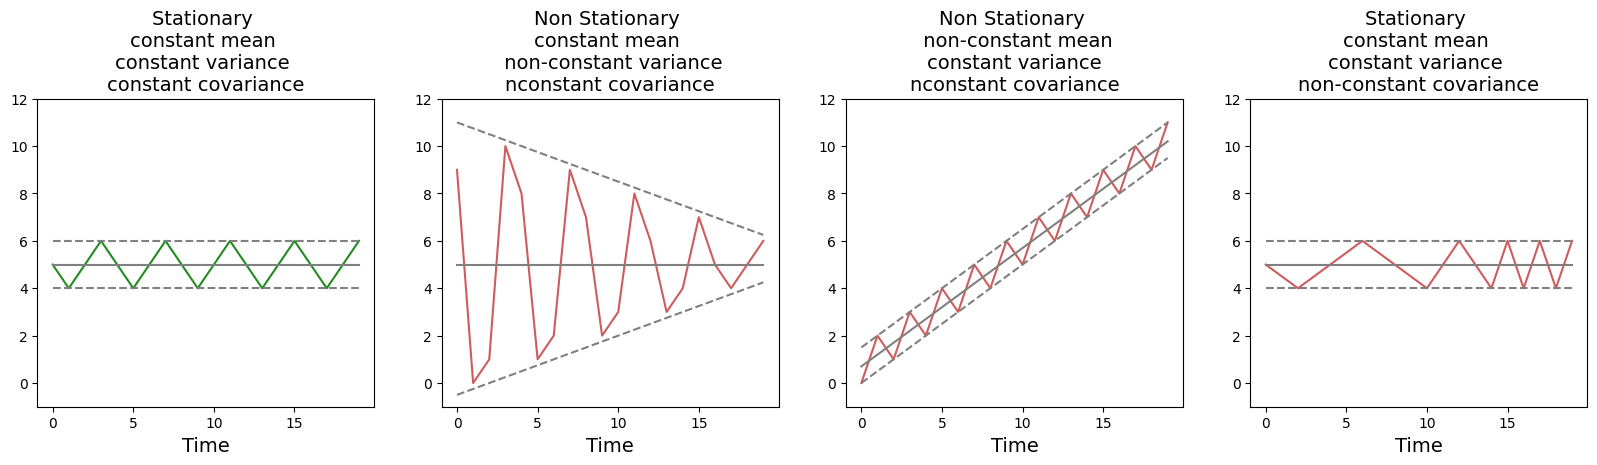

In [214]:
t = np.linspace(0, 19, 20)

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4))
stationary = [5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6,]
sns.lineplot(x=t, y=stationary, ax=ax[0], color='forestgreen')
sns.lineplot(x=t, y=5, ax=ax[0], color='grey')
sns.lineplot(x=t, y=6, ax=ax[0], color='grey')
sns.lineplot(x=t, y=4, ax=ax[0], color='grey')
ax[0].lines[2].set_linestyle("--")
ax[0].lines[3].set_linestyle("--")
ax[0].set_title(f'Stationary \nconstant mean \nconstant variance \nconstant covariance', fontsize=14)

nonstationary1 = [ 9, 0, 1, 10, 8, 1, 2, 9, 7, 2, 3, 8, 6, 3, 4, 7, 5, 4, 5, 6]
sns.lineplot(x=t, y=nonstationary1, ax=ax[1], color='indianred' )
sns.lineplot(x=t, y=5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*0.25-0.5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*(-0.25)+11, ax=ax[1], color='grey')
ax[1].lines[2].set_linestyle("--")
ax[1].lines[3].set_linestyle("--")
ax[1].set_title(f'Non Stationary \nconstant mean \n non-constant variance\nnconstant covariance', fontsize=14)

nonstationary2 = [0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11,]
sns.lineplot(x=t, y=nonstationary2, ax=ax[2], color='indianred' )
sns.lineplot(x=t, y=t*0.5+0.7, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5+1.5, ax=ax[2], color='grey')
ax[2].lines[2].set_linestyle("--")
ax[2].lines[3].set_linestyle("--")
ax[2].set_title(f'Non Stationary \n non-constant mean\nconstant variance\nnconstant covariance', fontsize=14)

nonstationary3 = [5, 4.5, 4, 4.5, 5, 5.5, 6, 5.5, 5, 4.5, 4, 5, 6, 5, 4, 6, 4, 6, 4, 6,]
sns.lineplot(x=t, y=nonstationary3, ax=ax[3], color='indianred')
sns.lineplot(x=t, y=5, ax=ax[3], color='grey')
sns.lineplot(x=t, y=6, ax=ax[3], color='grey')
sns.lineplot(x=t, y=4, ax=ax[3], color='grey')
ax[3].lines[2].set_linestyle("--")
ax[3].lines[3].set_linestyle("--")
ax[3].set_title(f'Stationary \nconstant mean \nconstant variance \nnon-constant covariance', fontsize=14)

for i in range(4):
    ax[i].set_ylim([-1, 12])
    ax[i].set_xlabel('Time', fontsize=14)

#### The check for stationarity can be done via three different approaches:

#### a.) visually: plot time series and check for trends or seasonality
#### b.) basic statistics: split time series and compare the mean and variance of each partition
#### c.) statistical test: Augmented Dickey Fuller test

In [215]:
ym_df.columns

Index(['original_release_ym', 'critic_sentiment_score',
       'synopsis_sentiment_score', 'tomatometer_rating', 'audience_rating'],
      dtype='object')

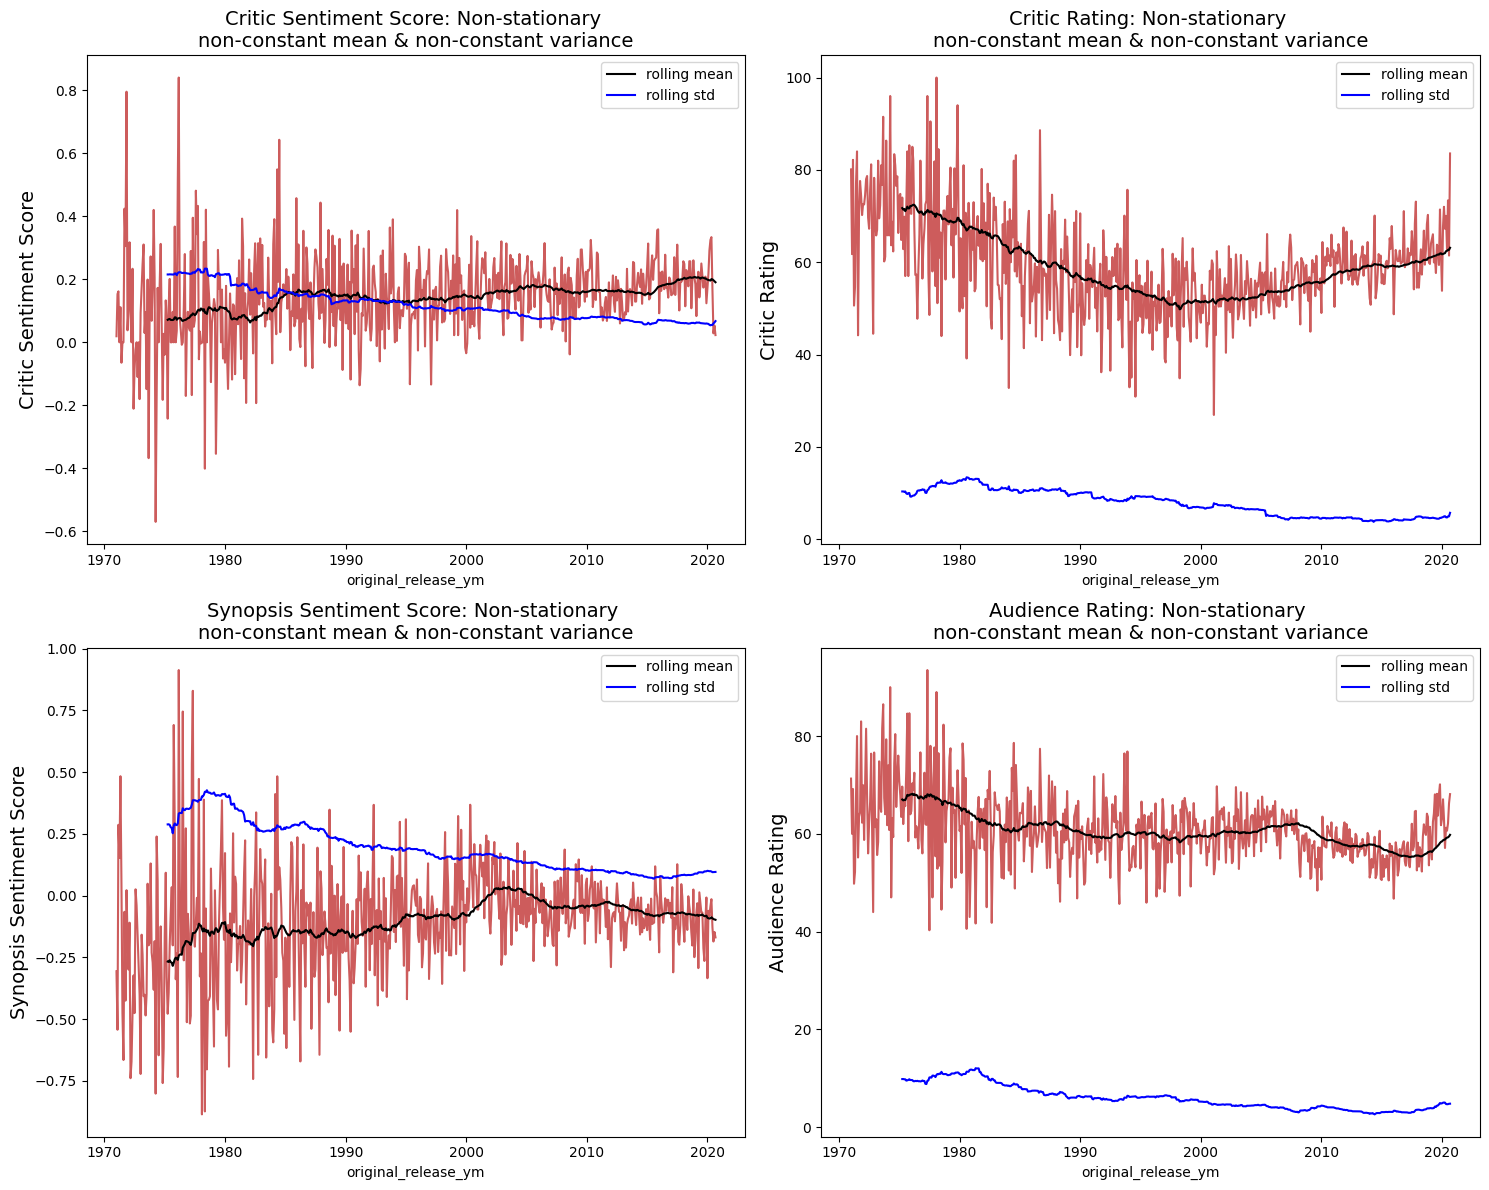

In [216]:
#Visual Test --> they all don't seem stationary, means and variances move around a bit
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['critic_sentiment_score'], ax=ax[0, 0], color='indianred')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['critic_sentiment_score'].rolling(rolling_window).mean(), ax=ax[0, 0], color='black', label='rolling mean')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['critic_sentiment_score'].rolling(rolling_window).std(), ax=ax[0, 0], color='blue', label='rolling std')
ax[0, 0].set_title('Critic Sentiment Score: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Critic Sentiment Score', fontsize=14)

sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['synopsis_sentiment_score'], ax=ax[1, 0], color='indianred')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['synopsis_sentiment_score'].rolling(rolling_window).mean(), ax=ax[1, 0], color='black', label='rolling mean')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['synopsis_sentiment_score'].rolling(rolling_window).std(), ax=ax[1, 0], color='blue', label='rolling std')
ax[1, 0].set_title('Synopsis Sentiment Score: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Synopsis Sentiment Score', fontsize=14)

sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['tomatometer_rating'], ax=ax[0, 1], color='indianred')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['tomatometer_rating'].rolling(rolling_window).mean(), ax=ax[0, 1], color='black', label='rolling mean')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['tomatometer_rating'].rolling(rolling_window).std(), ax=ax[0, 1], color='blue', label='rolling std')
ax[0, 1].set_title('Critic Rating: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Critic Rating', fontsize=14)

sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['audience_rating'], ax=ax[1, 1], color='indianred')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['audience_rating'].rolling(rolling_window).mean(), ax=ax[1, 1], color='black', label='rolling mean')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['audience_rating'].rolling(rolling_window).std(), ax=ax[1, 1], color='blue', label='rolling std')
ax[1, 1].set_title('Audience Rating: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Audience Rating', fontsize=14)


plt.tight_layout()
plt.show()

In [217]:
#Test #2: Underlying Statistics --> sentiment scores seem stationary as not much difference between chunks
num_partitions = 2
partition_length = int(len(ym_df) / num_partitions)

partition1_mean = ym_df.head(partition_length).mean()
partition1_var = ym_df.head(partition_length).var()
partition2_mean = ym_df.tail(partition_length).mean()
partition2_var = ym_df.tail(partition_length).var()

In [218]:
stationarity_test = pd.concat([partition1_mean, partition2_mean, partition1_var, partition2_var], axis=1)
stationarity_test.columns = ['Partition 1 Mean', 'Partition 2 Mean', 'Partition 1 Variance', 'Partition 2 Variance']

def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition 1 Mean'] == temp['Partition 2 Mean'])
    m2 = (temp['Partition 1 Variance'] == temp['Partition 2 Variance'])
    m3 = (temp['Partition 1 Mean'] < temp['Partition 2 Mean']+3) & (temp['Partition 1 Mean'] > temp['Partition 2 Mean']-3)
    m4 = (temp['Partition 1 Variance'] < temp['Partition 2 Variance']+3) & (temp['Partition 1 Variance'] > temp['Partition 2 Variance']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition 1 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Mean'])

    df1['Partition 1 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Variance'])

    return df1


stationarity_test.style.apply(highlight_greater, axis=None).format("{:20,.0f}")


,Partition 1 Mean,Partition 2 Mean,Partition 1 Variance,Partition 2 Variance
critic_sentiment_score,0,0,0,0
synopsis_sentiment_score,-0,-0,0,0
tomatometer_rating,62,57,156,47
audience_rating,63,59,78,21


In [219]:
ym_df.columns

Index(['original_release_ym', 'critic_sentiment_score',
       'synopsis_sentiment_score', 'tomatometer_rating', 'audience_rating'],
      dtype='object')

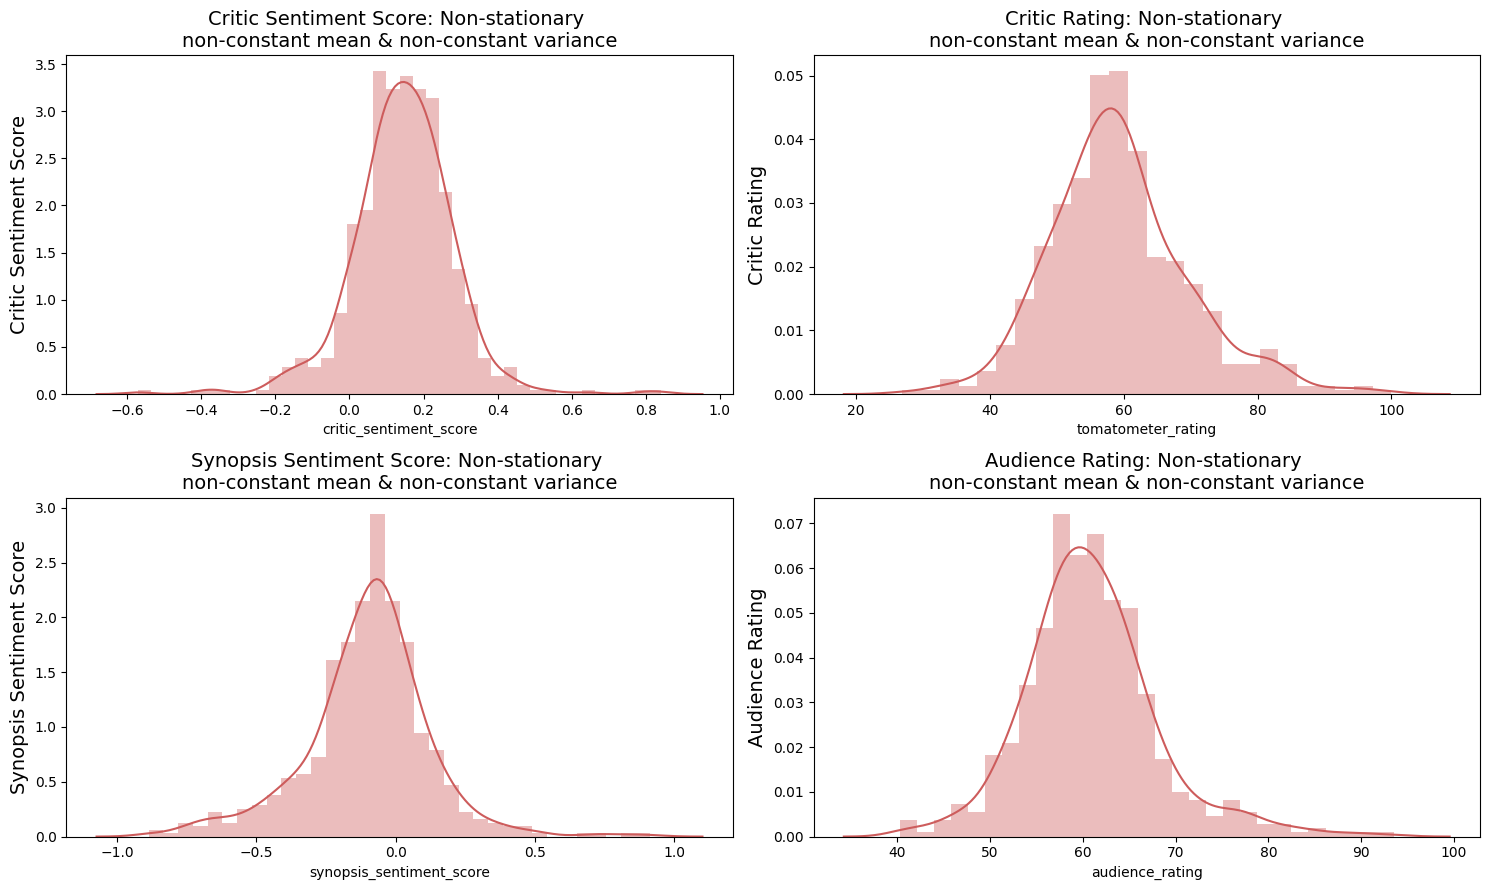

In [220]:
#Let's evaluate the histograms. Since we are looking at the mean and variance, we are expecting 
#that the data conforms to a Gaussian distribution (bell shaped distribution) in case of stationarity.

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

sns.distplot(ym_df['critic_sentiment_score'], ax=ax[0, 0], color='indianred')
ax[0, 0].set_title('Critic Sentiment Score: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Critic Sentiment Score', fontsize=14)

sns.distplot(ym_df['synopsis_sentiment_score'], ax=ax[1, 0], color='indianred')
ax[1, 0].set_title('Synopsis Sentiment Score: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Synopsis Sentiment Score', fontsize=14)

sns.distplot(ym_df['tomatometer_rating'], ax=ax[0, 1], color='indianred')
ax[0, 1].set_title('Critic Rating: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Critic Rating', fontsize=14)

sns.distplot(ym_df['audience_rating'], ax=ax[1, 1], color='indianred')
ax[1, 1].set_title('Audience Rating: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Audience Rating', fontsize=14)


plt.tight_layout()
plt.show()


## Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

#### Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

#### Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

#### If the null hypothesis can be rejected, we can conclude that the time series is stationary.

In [221]:
ym_df.columns

Index(['original_release_ym', 'critic_sentiment_score',
       'synopsis_sentiment_score', 'tomatometer_rating', 'audience_rating'],
      dtype='object')

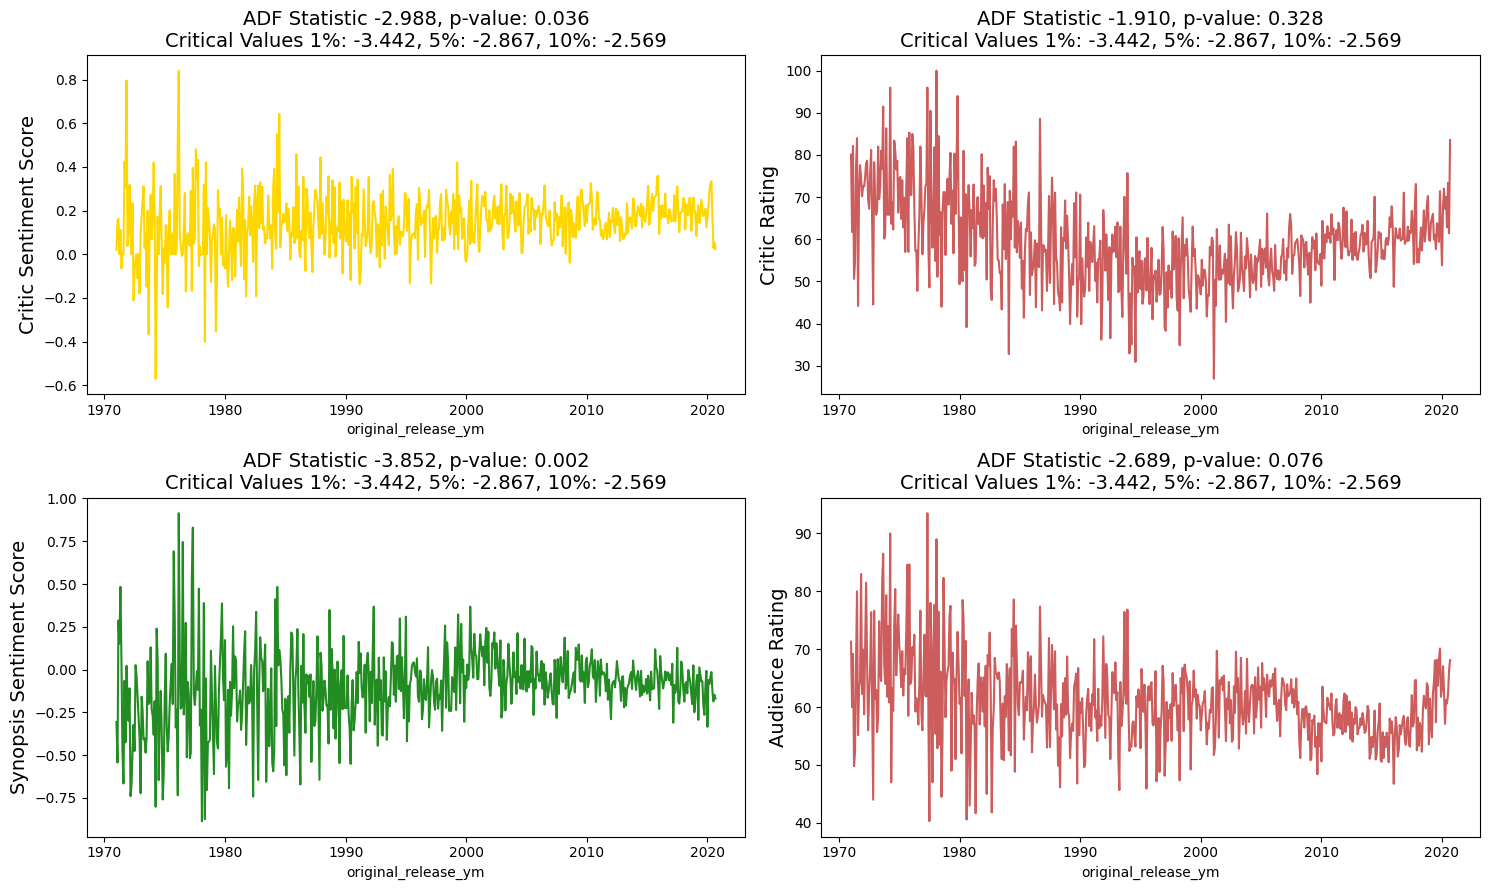

In [246]:
from statsmodels.tsa.stattools import adfuller

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=ym_df['original_release_ym'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(ym_df['critic_sentiment_score'].values, 'Critic Sentiment Score', ax[0, 0])
visualize_adfuller_results(ym_df['synopsis_sentiment_score'].values, 'Synopsis Sentiment Score', ax[1, 0])
visualize_adfuller_results(ym_df['tomatometer_rating'].values, 'Critic Rating', ax[0, 1])
visualize_adfuller_results(ym_df['audience_rating'].values, 'Audience Rating', ax[1, 1])

plt.tight_layout()
plt.show()

In [226]:
#Sentiment scores --> stationary
#critic and audience ratings --> not stationary

#### If the data is not stationary, the data has to be transformed. However, if the data is not stationary to begin with, we should rethink the choice of model.

#### The two most common methods to achieve stationarity are:

#### a.) Transformation: e.g. log or square root to stabilize non-constant variance
#### b.) Differencing: subtracts the current value from the previous

In [227]:
# Log Transform of absolute values
ym_df['tomatometer_rating_log'] = np.log(abs(ym_df['tomatometer_rating']))
ym_df['audience_rating_log'] = np.log(abs(ym_df['audience_rating']))

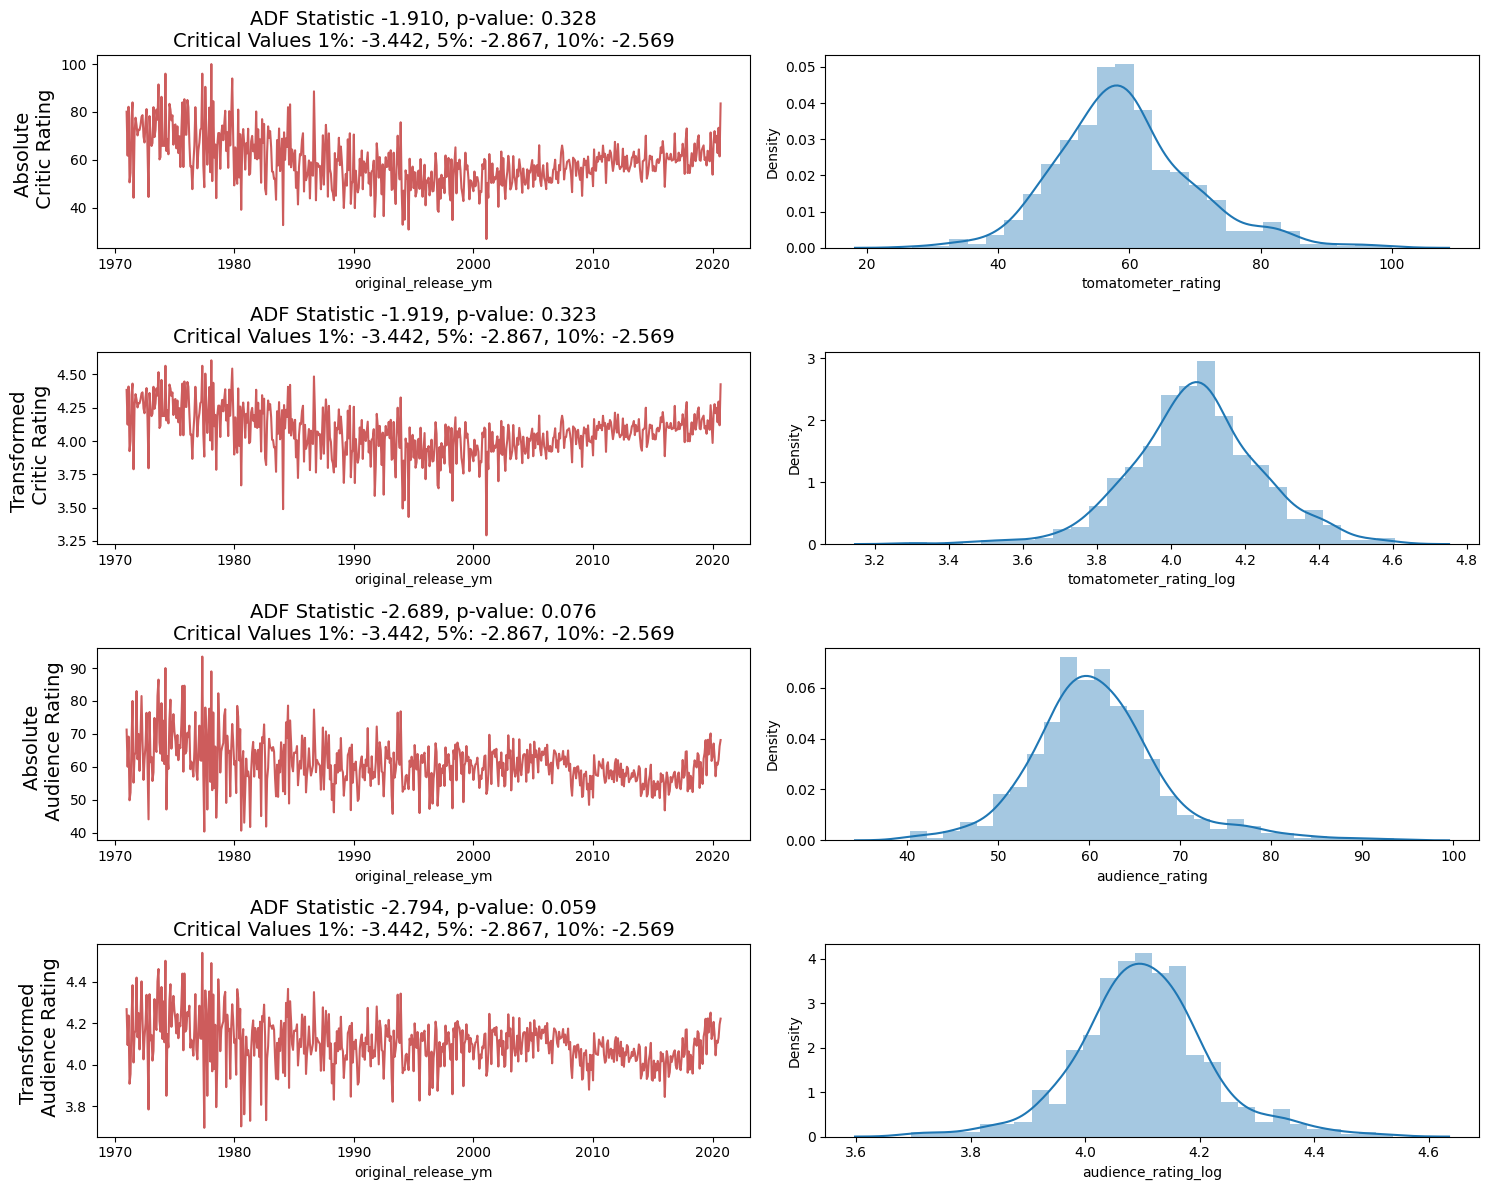

In [260]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))

#----------Plot normal vs. transformed critic rating----------#
visualize_adfuller_results(abs(ym_df['tomatometer_rating']), 'Absolute \n Critic Rating', ax[0, 0])
sns.distplot(ym_df['tomatometer_rating'], ax=ax[0, 1])

visualize_adfuller_results(ym_df['tomatometer_rating_log'], 'Transformed \n Critic Rating', ax[1, 0])
sns.distplot(ym_df['tomatometer_rating_log'], ax=ax[1, 1])


#----------Plot normal vs. transformed audience rating----------#
visualize_adfuller_results(abs(ym_df['audience_rating']), 'Absolute \n Audience Rating', ax[2, 0])
sns.distplot(ym_df['audience_rating'], ax=ax[2, 1])

visualize_adfuller_results(ym_df['audience_rating_log'], 'Transformed \n Audience Rating', ax[3, 0])
sns.distplot(ym_df['audience_rating_log'], ax=ax[3, 1])

plt.tight_layout()
plt.show()

In [263]:
#1.) First Order Differencing - Critic Rating
ts_diff = np.diff(ym_df['tomatometer_rating'])
ym_df['tomatometer_rating_diff1'] = np.append([0], ts_diff)

#2.) Second Order Differencing - Critic Rating
ts_diff = np.diff(ym_df['tomatometer_rating_diff1'])
ym_df['tomatometer_rating_diff2'] = np.append([0], ts_diff)

#3.) First Order Differencing - Audience Rating
ts_diff = np.diff(ym_df['audience_rating'])
ym_df['audience_rating_diff1'] = np.append([0], ts_diff)

#4.) Second Order Differencing - Audience Rating
ts_diff = np.diff(ym_df['audience_rating_diff1'])
ym_df['audience_rating_diff2'] = np.append([0], ts_diff)

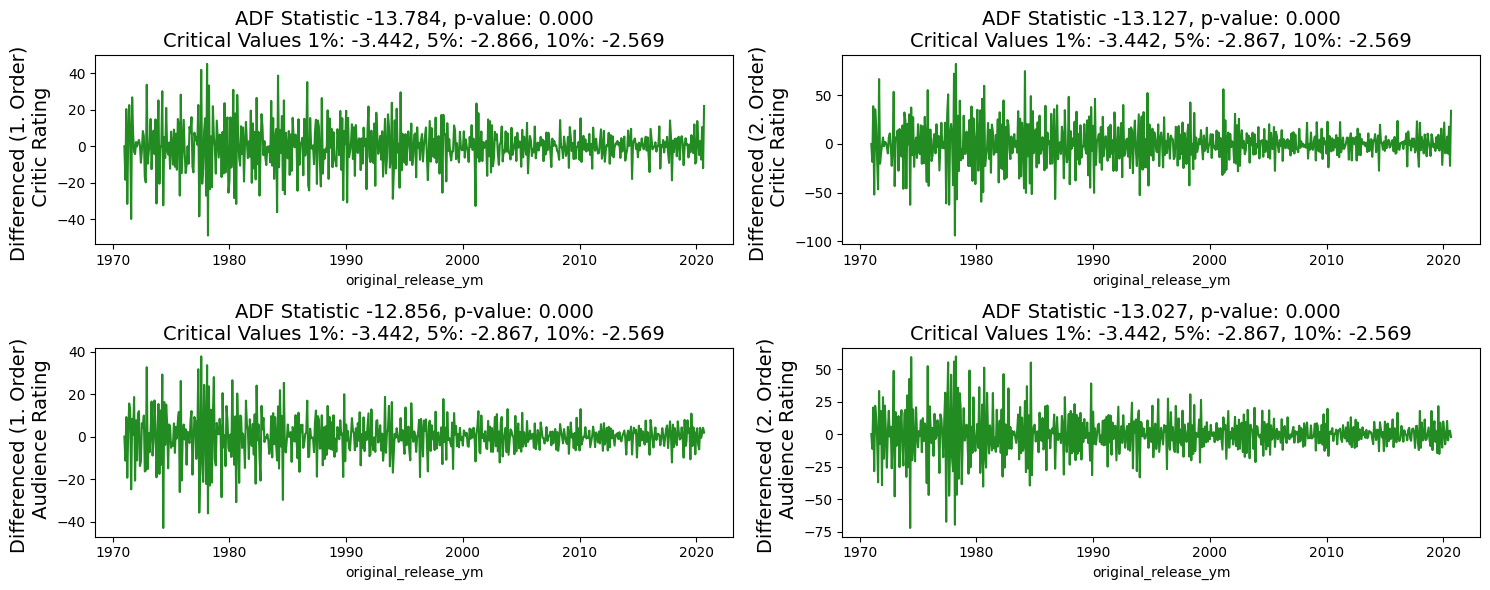

In [265]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))

visualize_adfuller_results(ym_df['tomatometer_rating_diff1'], 'Differenced (1. Order) \n Critic Rating', ax[0,0])
visualize_adfuller_results(ym_df['tomatometer_rating_diff2'], 'Differenced (2. Order) \n Critic Rating', ax[0,1])
visualize_adfuller_results(ym_df['audience_rating_diff1'], 'Differenced (1. Order) \n Audience Rating', ax[1,0])
visualize_adfuller_results(ym_df['audience_rating_diff2'], 'Differenced (2. Order) \n Audience Rating', ax[1,1])

plt.tight_layout()
plt.show()

## Feature Engineering